© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

In [1]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

## 📉 Homework 7 — Primal SVM Training with Learning Rate Scheduling

The goal of this task is to improve the **training stability** of gradient descent on the **primal SVM** formulation by using **learning rate scheduling**.

We will use a **synthetic dataset** consisting of two **linearly separable Gaussian blobs** to clearly observe the behavior of optimization with and without scheduling.

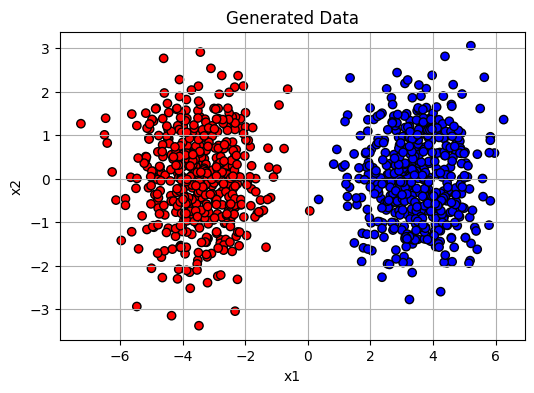

In [2]:
def generate_data(n=200, distance_between_classes=6):

    mu1 = np.array([-distance_between_classes/2,0.])
    mu2 = np.array([distance_between_classes/2,0.])
    sigma1 = np.array([[1., 0], [0, 1.]])
    sigma2 = np.array([[1., 0], [0, 1.]])
 
    X1 = np.random.multivariate_normal(mu1, sigma1, n//2)
    X2 = np.random.multivariate_normal(mu2, sigma2, n//2)

    X = np.vstack((X1, X2))
    y = np.hstack((np.ones(n//2), -np.ones(n//2)))

    return X, y.astype(int)

fig, ax = plt.subplots(figsize=(6, 4))
X, Y = generate_data(n=1000, distance_between_classes=7.0) 

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolor='k')

plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.title("Generated Data")

fig.savefig("data.png", dpi=300, bbox_inches='tight')

## GD Implementation with Learning Rate Scheduling

We now extend our GD implementation to include an optional **learning rate schedule**.

Instead of using a fixed step size, we update the learning rate at each step according to a user-defined schedule:

> 💡 **Example schedule** (inverse decay):  
> $$
> \eta_t = \frac{\eta_0}{1 + \gamma t}
> $$

This can help:
- Improve **stability** during training
- Avoid **overshooting** minima in later epochs
- Achieve **faster convergence** 

We implement `GDOptimizer` class, which supports passing a function of the form `schedule_fn(t)` to dynamically adjust the step size.

In [3]:
from courselib.optimizers import Optimizer

class GDOptimizer(Optimizer):
    """
    Gradient descent optimizer with optional learning rate schedule.

    Parameters:
    - learning_rate (float): Initial learning rate
    - schedule_fn (callable): Function(step) → new_learning_rate
    """

    def __init__(self, learning_rate=0.01, schedule_fn=None):
        super().__init__(learning_rate)
        self.schedule_fn = schedule_fn
        self.step = 0

    def update(self, params, grads):
        if self.schedule_fn is not None:
            self.step += 1
            self.learning_rate = self.schedule_fn(self.step)

        for key in params:
            np.subtract(params[key], self.learning_rate * grads[key], out=params[key])


We also implement the **inverse decay schedule** function:

In [4]:
def decay_schedule(step, initial_lr=0.1, decay_rate=0.01):
    return initial_lr / (1 + decay_rate * step)

### 📊 Metrics

As stated in the task, we implement the following evaluation metrics for monitoring SVM training:

- 🔢 **Loss**:  
  Hinge loss (average per sample):  
  $$
  \mathcal{L}_{\text{hinge}} = \frac{1}{N} \sum_{i=1}^N \max(0,\ 1 - y_i \cdot h(x_i))
  $$

- ✅ **Accuracy**:  
  Binary classification accuracy:  
  $$
  \text{Accuracy} = \frac{1}{N} \sum_{i=1}^N \mathbb{1}[y_i = \text{sign}(h(x_i))]
  $$

- 📏 **Mean margin**:  
  The average signed margin:  
  $$
  \frac{1}{N} \sum_{i=1}^N y_i \cdot h(x_i)
  $$

- ❌ **Number of margin violations**:  
  Total number of samples that violate the margin condition ($y_i \cdot h(x_i) < 1$):  
  $$
  \sum_{i=1}^N \mathbb{1}[y_i \cdot h(x_i) < 1]
  $$


In [5]:
from courselib.utils.metrics import binary_accuracy

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[-1,1]), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred)),
                "margin": lambda y_pred, y_true: np.mean(y_true * y_pred),
                "violations": lambda y_pred, y_true: np.sum(y_true * y_pred < 1)}

## 🏋️ Train and Evaluate

We now train **SVM models** using gradient descent with and without **learning rate scheduling**, across different values of:

- The regularization strength $C$
- The initial learning rate $\eta$

For each configuration, we evaluate the model on the above metrics and track the training dynamics.

### ⚠️ Stability Monitoring

Gradient descent may become **unstable** for large $C$ or poorly chosen learning rates, leading to divergence:

- We explicitly check for **numerical overflow**, i.e., when model parameters (`w`) become `NaN` or `inf`.
- This typically results in a **critical drop in accuracy**.

In [ ]:
from courselib.models.svm import LinearSVM

C_vals = [1.0, 10.0, 100.0, 1000.0]
lr_vals = [1e-1, 1e-2, 1e-3]

results_schedule = []
results_no_schedule = []


for i, C in enumerate(C_vals):
    for lr in lr_vals:

        w0 = [0.0, 0.0]
        b0 = 0.0

        opt_schedule = GDOptimizer(schedule_fn = lambda step: decay_schedule(step, initial_lr=lr, decay_rate=0.1))
        opt_no_schedule = GDOptimizer(learning_rate=lr)

        svm_schedule = LinearSVM(w0, b0, opt_schedule, C=C)
        svm_no_schedule = LinearSVM(w0, b0, opt_no_schedule, C=C)

        metrics_history_schedule = svm_schedule.fit(X, Y, 
                                                num_epochs=10**5, 
                                                batch_size=len(X), 
                                                compute_metrics=True, 
                                                metrics_dict=metrics_dict)


        metrics_history_no_schedule = svm_no_schedule.fit(X, Y, 
                                                num_epochs=10**5, 
                                                batch_size=len(X), 
                                                compute_metrics=True, 
                                                metrics_dict=metrics_dict)
        


        for model, name, results, metrics_history in zip([svm_schedule, svm_no_schedule],
                                                    ['SVM with schedule', 'SVM without schedule'],
                                                   [results_schedule, results_no_schedule],
                                                   [metrics_history_schedule, metrics_history_no_schedule]):

            row = {'C': C, 'lr': lr}
            if not np.all(np.isfinite(model.w)):
                print(f"Weights became nan (overflow) for {name} at C={C}, lr={lr}")
                row['w_overflow'] = True
            else:
                row['w_overflow'] = False

            row.update({'margin': metrics_history['margin'], 
                        'violations': metrics_history['violations'],
                        'loss': metrics_history['loss'],
                        'accuracy': metrics_history['accuracy']})
            results.append(row)

plt.show()

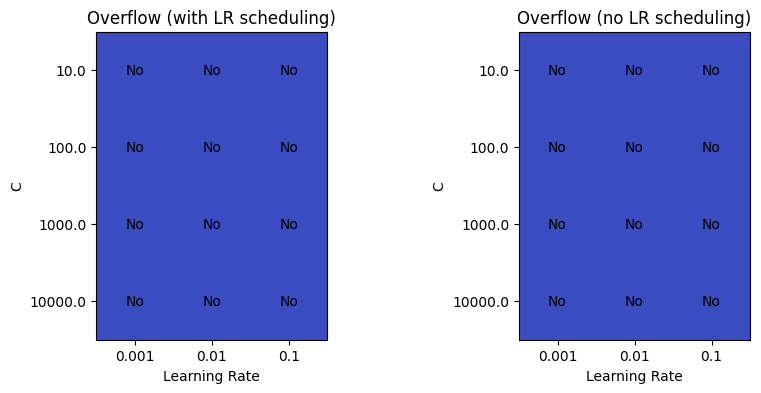

In [19]:
fix, axs = plt.subplots(1, 2, figsize=(10, 4))


for results_df, title, ax in zip([results_schedule, results_no_schedule],
                                 ["Overflow (with LR scheduling)", "Overflow (no LR scheduling)"],
                                  axs):
    

    results_df = pd.DataFrame(results_df)
    pivot = results_df.pivot(index='C', columns='lr', values='w_overflow')

    # Convert boolean to integer for plotting
    matrix = pivot.astype(int)

    im = ax.imshow(matrix, cmap='coolwarm', vmin=0, vmax=1)

    # Show text annotations (True/False)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = 'Yes' if matrix.iat[i, j] else 'No'
            ax.text(j, i, text, ha='center', va='center', color='black')

    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_xticklabels(matrix.columns)
    ax.set_yticklabels(matrix.index)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("C")
    ax.set_title(title)

One can see that the scheduler prevents overflow in many of the considered cases. 

### 📈 Learning Curves and Metrics

We now visualize the training dynamics using the metrics logged during optimization.

As expected:

- Models that experience **overflow** exhibit a **sudden drop in accuracy** to 50%. Once the parameters diverge, the model does not recover.
- In contrast, the stable models achieve **perfect accuracy**, due to the **linear separability** of the data.


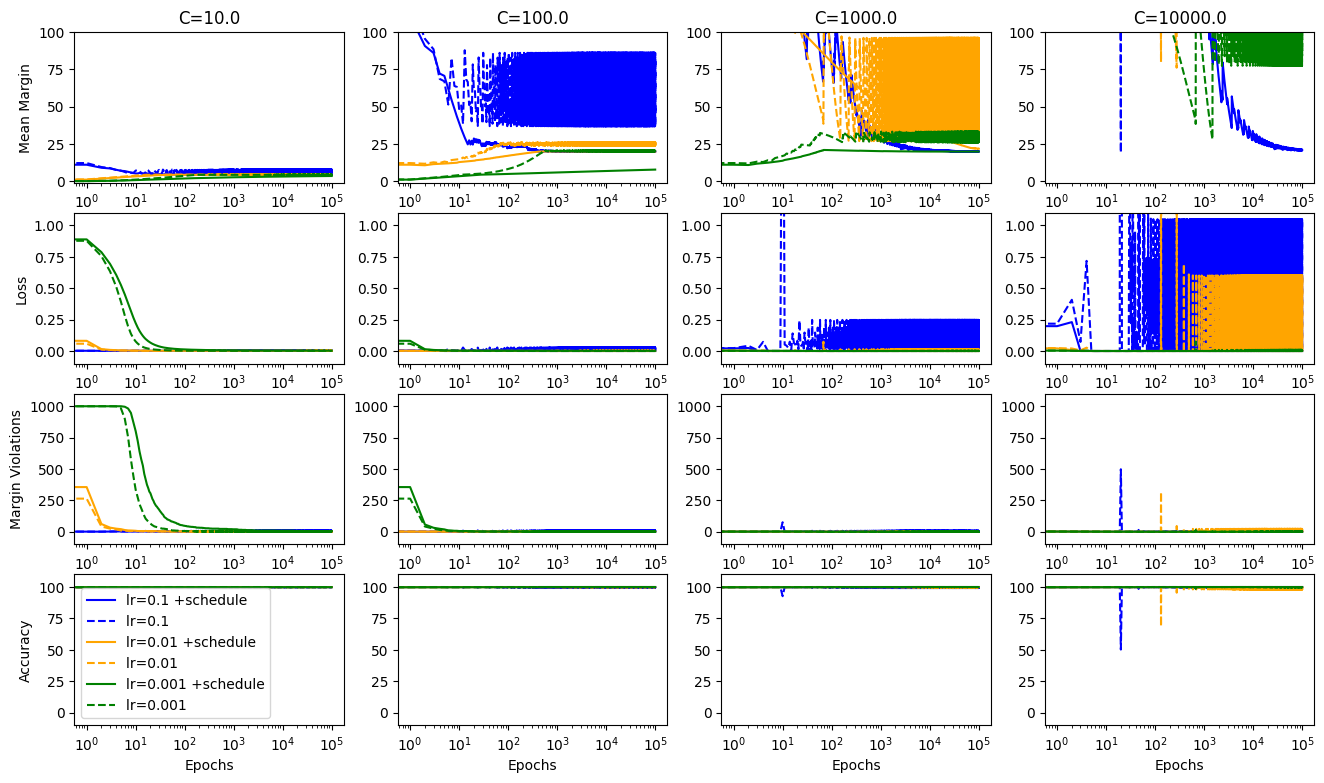

In [20]:
import pandas as pd
results_schedule, results_no_schedule = pd.DataFrame(results_schedule), pd.DataFrame(results_no_schedule)

fig, axs = plt.subplots(4, len(C_vals),figsize=(16, 9))

for ax,C in zip(axs.T, C_vals):
    for lr,color in zip(lr_vals, ['blue', 'orange', 'green']):
        for results, ls, label in zip([results_schedule, results_no_schedule], ['-','--'], ['+schedule', '']):
            ax[0].plot(results[(results['C'] == C) & (results['lr'] == lr)]['margin'].iloc[0],
                       linestyle=ls, color=color)
            ax[0].set_xscale('log')
            ax[0].set_title(f"C={C}")
            ax[0].set_ylim(-1.,100)

            ax[1].plot(results[(results['C'] == C) & (results['lr'] == lr)]['loss'].iloc[0],
                       linestyle=ls, color=color)
            ax[1].set_xscale('log')
            ax[1].set_ylim(-0.1,1.1)
            
            ax[2].plot(results[(results['C'] == C) & (results['lr'] == lr)]['violations'].iloc[0],
                       linestyle=ls, color=color)
            ax[2].set_xscale('log')
            ax[2].set_ylim(-100.,1100.)

            ax[3].plot(results[(results['C'] == C) & (results['lr'] == lr)]['accuracy'].iloc[0],
                       label=f"lr={lr} {label}",
                       linestyle=ls, color=color)
            ax[3].set_xscale('log')
            ax[3].set_xlabel("Epochs")
            ax[3].set_ylim(-10.,110.)



axs[0,0].set_ylabel("Mean Margin")
axs[1,0].set_ylabel("Loss")
axs[2,0].set_ylabel("Margin Violations")
axs[3,0].set_ylabel("Accuracy")
axs[3,0].legend()

### 🗺️ Loss Landscape Visualization

To further investigate the **instability of GD** when optimizing the **hinge loss**, we visualize the **loss landscape** of the soft-margin SVM.

One can observe the following:

- The landscape contains both **very steep** and **very flat** regions.
- The global minima typically lie in flat basins, where the gradient is close to zero.

> ⚠️ **Large gradients in steep regions lead to oversized GD updates**, which can overshoot and destabilize convergence — especially when entering flat regions that require smaller, careful steps.


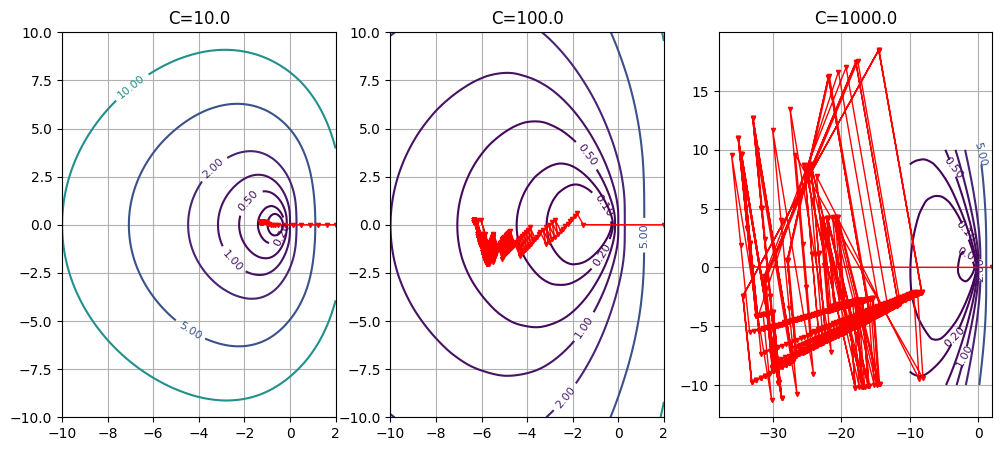

In [21]:
fix, axs = plt.subplots(1, 3, figsize=(12, 5))

def hinge_loss(w):
    y_true = Y
    y_pred = X @ w
    return C*np.mean(np.maximum(0, 1 - y_true * y_pred)) + np.linalg.norm(w)**2

w1_range = np.linspace(-10, 2, 500)
w2_range = np.linspace(-10, 10, 500)
W1, W2 = np.meshgrid(w1_range, w2_range)

levels = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]

for C, ax in zip([10.,100.,1000.],axs):

    Z = np.zeros(W1.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = hinge_loss(np.array([W1[i, j], W2[i, j]]))/C

    CS = ax.contour(W1, W2, Z, levels=levels)
    ax.clabel(CS, inline=1, fontsize=8) 
    ax.grid()

    w0 = np.array([2,0])
    lr = 0.01
    K = 1000
    history = [w0]

    for k in range(K):
        w = history[-1]
        svm = LinearSVM(w, 0.0, optimizer=opt_no_schedule, C=C)
        grad = svm.loss_grad(X,Y)['w']
        w = w - lr*grad
        history.append(w.copy())

    history = np.array(history)
    ax.plot(history[:,0],history[:,1], '-v', ms=3, color='red', linewidth=1) 
    ax.set_title(f"C={C}")